# Тема 3.6. Логирование и анализ полетных данных

## Немного общей теории

### Определение

**Логирование** - процесс записи событий, происходящих в системе, программе или приложении, в специальные файлы-журналы (логи). Он помогает отслеживать работу системы, находить и анализировать ошибки, а также понимать, что и когда происходило, что является ключевым инструментом для разработчиков и администраторов.

### Форматы хранения логов

#### CSV

Описание: Текстовый файл, где данные разделены запятыми (или точкой с запятой). Самый популярный формат для табличных данных

Плюсы:

- Человекочитаемость
- Легкая интеграция с библиотеками анализа
- Простота реализации

Минусы:

- Плохо подходит для иерархических данных (вложенных структур)
- Проблемы с разделителями (если в данных есть запятые)
- Занимает больше места, чем бинарный формат

#### JSON

Описание: Текстовый формат для хранения структурированных данных (словари, списки)

Плюсы:

- Поддержка сложной вложенности
- "Самодокументируемость" (поля имеют имена)

Минусы:

- Избыточность (названия полей повторяются в каждой записи, много скобок)
- Медленный парсинг по сравнению с CSV/Binary (как раз из-за избыточности)

#### Binary

Описание: Запись байтов напрямую в память файла

Примечание: рассматривать на семинаре его не будем, но важно знать, что именно с ним работает MAVLink

Плюсы:

- Максимальная компактность (экономия места в памяти дрона)
- Максимальная скорость записи (критично для микроконтроллеров и частот > 100Гц)

Минусы:

- Нельзя прочитать "глазами"
- Зависимость от архитектуры (например, от endianness — порядка записи байтов)
- Нужно знать точную структуру для расшифровки (что из данных было целым, что float'ом, что строчкой)

### Уровни логирования

![Log Levels](log_levels.png)

## Организация логирования в Python

### Библиотека `logging`

In [1]:
import logging
import sys

# Создадим сам логгер
logger = logging.getLogger("DroneController")
logger.setLevel(logging.DEBUG)

# Добавим обработчик для вывода в консоль
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)

# Добавим обработчик для вывода в файл
file_handler = logging.FileHandler("flight_data.csv", mode='w')
file_handler.setLevel(logging.DEBUG)

logger.addHandler(console_handler)
logger.addHandler(file_handler)

# Создадим форматтеры для красоты вывода
console_formatter = logging.Formatter("%(asctime)s :: %(levelname)s :: %(message)s")
file_formatter = logging.Formatter("%(message)s")

console_handler.setFormatter(console_formatter)
file_handler.setFormatter(file_formatter)

# Базовый фильтр ничего не умеет, поэтому создадим класс-наследник, который будет оставлять только записи нужного нам уровня
class SingleLevelFilter(logging.Filter):
  def __init__(self, level):
    self.level = level

  def filter(self, record):
    return (record.levelno == self.level)
  
file_filter = SingleLevelFilter(logging.DEBUG)
file_handler.addFilter(file_filter)

# Файл предполагается csv - закинем в него шапку
logger.debug("timestamp,x,y,z,vx,vy,vz")
# Проверим также работоспособность вывода в консоль
logger.info("OK")

2025-12-04 17:51:38,742 :: INFO :: OK


Наконец создадим файл логов, запустив простенькую полетную миссию

In [2]:
import numpy as np
import time

from control import ROSInterface

drone = ROSInterface(logger=logger)
time.sleep(2)
drone.takeoff(5.0)
drone.fly_to_pose(np.array([20.0, 15.0, 10.0]))
drone.fly_to_pose(np.array([0.0, 0.0, 5.0]))
drone.shutdown()

2025-12-04 17:51:39,306 :: INFO :: ROS 2 node initialized.
2025-12-04 17:51:39,324 :: INFO :: ROS 2 spin thread started.
2025-12-04 17:51:41,326 :: INFO :: Takeoff to altitude 5.0
2025-12-04 17:51:50,855 :: INFO :: Flying to pose [20. 15. 10.]
2025-12-04 17:52:18,303 :: INFO :: Flying to pose [0. 0. 5.]
2025-12-04 17:52:45,826 :: INFO :: Shutting down Drone Controller...
2025-12-04 17:52:45,826 :: INFO :: Waiting for spin thread to finish...
2025-12-04 17:52:45,833 :: INFO :: ROS 2 spin thread stopped.
2025-12-04 17:52:45,834 :: INFO :: Destroying node drone_controller...
2025-12-04 17:52:45,836 :: INFO :: Node destroyed.
2025-12-04 17:52:45,836 :: INFO :: Shutting down rclpy...
2025-12-04 17:52:45,837 :: INFO :: rclpy shut down.
2025-12-04 17:52:45,837 :: INFO :: Drone Controller shutdown complete.


## Визуализация и анализ данных

Как принято, начнем с импортов

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Получим датафрейм из файла логов

In [4]:
df = pd.read_csv('flight_data.csv')
df.head()

,timestamp,x,y,z,vx,vy,vz
0,1.764853e+09,1.007993e-11,-8.624912e-19,0.561248,1.648383e-12,6.419355e-19,0.001000
1,1.764853e+09,1.015358e-11,-8.655595e-19,0.561289,1.942749e-12,-1.340867e-19,0.001000
2,1.764853e+09,3.516371e-11,-3.749562e-16,0.561399,2.707058e-09,-4.099741e-14,0.007498
3,1.764853e+09,3.975392e-09,5.951543e-14,0.562078,1.932761e-07,2.932632e-12,0.030789
4,1.764853e+09,4.290223e-08,1.293542e-12,0.564135,1.264624e-06,4.083443e-11,0.063699


In [5]:
# Сдвинем временные метки
df['timestamp'] -= df.loc[0]['timestamp']

In [6]:
df.head()

,timestamp,x,y,z,vx,vy,vz
0,0.000000,1.007993e-11,-8.624912e-19,0.561248,1.648383e-12,6.419355e-19,0.001000
1,0.033609,1.015358e-11,-8.655595e-19,0.561289,1.942749e-12,-1.340867e-19,0.001000
2,0.067158,3.516371e-11,-3.749562e-16,0.561399,2.707058e-09,-4.099741e-14,0.007498
3,0.100686,3.975392e-09,5.951543e-14,0.562078,1.932761e-07,2.932632e-12,0.030789
4,0.134223,4.290223e-08,1.293542e-12,0.564135,1.264624e-06,4.083443e-11,0.063699


Посмотрим на траекторию в 3D

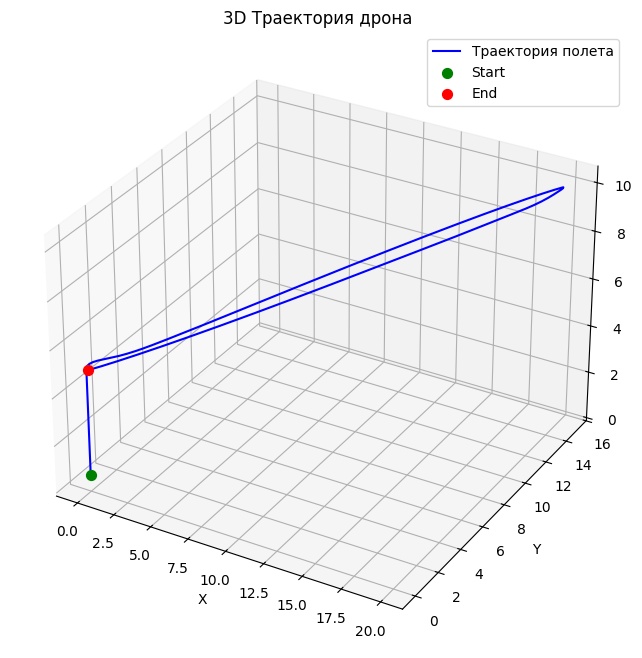

In [7]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Строим траекторию
ax.plot(df['x'], df['y'], df['z'], label='Траектория полета', color='b')

# Обозначим старт и финиш
ax.scatter(df['x'].iloc[0], df['y'].iloc[0], df['z'].iloc[0], color='g', s=50, label='Start')
ax.scatter(df['x'].iloc[-1], df['y'].iloc[-1], df['z'].iloc[-1], color='r', s=50, label='End')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.title("3D Траектория дрона")
plt.show()

Построим график изменения модуля скорости во времени

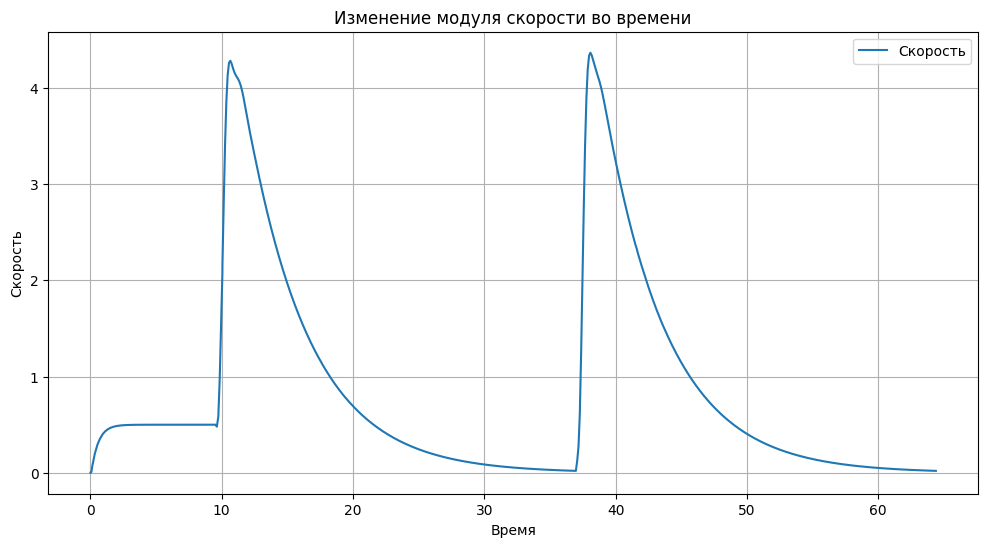

In [8]:
df['v'] = np.sqrt(df['vx']**2 + df['vy']**2 + df['vz']**2)

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['v'], label='Скорость')
plt.xlabel('Время')
plt.ylabel('Скорость')
plt.title('Изменение модуля скорости во времени')
plt.grid(True)
plt.legend()
plt.show()

Теперь давайте добавим в значения скорости шум и еще раз посмотрим на график

In [9]:
# Генерируем нормальный шум (среднее 0, станд. отклонение 0.5)
noise = np.random.normal(0, 0.5, size=len(df))

# Добавляем шум к идеальной скорости
df['v_noisy'] = df['v'] + noise

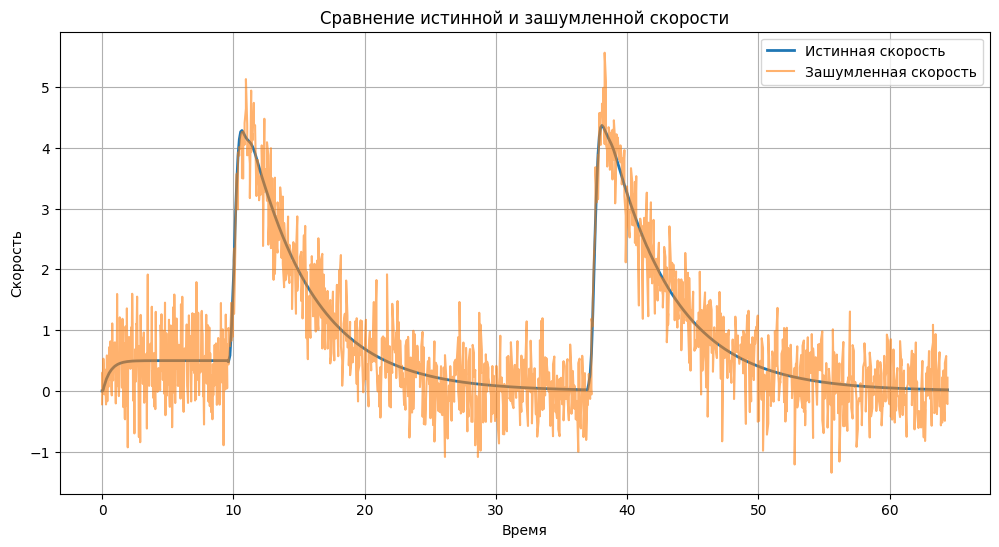

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(df['timestamp'], df['v'], label='Истинная скорость', linewidth=2)
plt.plot(df['timestamp'], df['v_noisy'], label='Зашумленная скорость', alpha=0.6)

plt.xlabel('Время')
plt.ylabel('Скорость')
plt.title('Сравнение истинной и зашумленной скорости')
plt.grid(True)
plt.legend()
plt.show()